In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from keras.applications.vgg16 import VGG16
# Some utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import  image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import numpy as np

In [6]:
myTrainDir = r"C:\Users\agusa\OneDrive\Escritorio\Ing\IA\DataResos\Dataset"
target_sz = (128, 128)


train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(myTrainDir,
                                                 target_size=target_sz,
                                                 batch_size=20,
                                                 class_mode='categorical',                                                 
                                                 shuffle=False, 
                                                 seed=20 )
x1=np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
y1=np.concatenate([train_generator.next()[1] for i in range(train_generator.__len__())])
print(x1.shape)
print(y1.shape)
labels = list(train_generator.class_indices.keys())  
print(labels)

shuffler = np. random. permutation(len(y1))
x1 = x1[shuffler]
y1 = y1[shuffler]


Found 6400 images belonging to 4 classes.
(6400, 128, 128, 3)
(6400, 4)
['Enfermedad Leve', 'Enfermedad Moderada', 'Enfermedad Severa', 'Sano']


In [7]:
# load model
model = VGG16()
# summarize the model
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 0. 0. 1.]
Sano


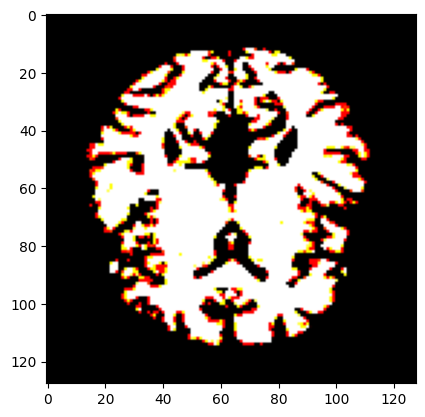

In [8]:
n=6

plt.imshow(x1[n])
print(y1[n])
print(labels[np.argmax(y1[n])])

In [9]:
lb = [labels[np.argmax(x)] for x in y1[:10]]
for lb_enc, lb in zip(y1[:10],lb):
    print(lb_enc,"-->",lb)

[1. 0. 0. 0.] --> Enfermedad Leve
[0. 1. 0. 0.] --> Enfermedad Moderada
[1. 0. 0. 0.] --> Enfermedad Leve
[0. 0. 0. 1.] --> Sano
[0. 0. 0. 1.] --> Sano
[0. 1. 0. 0.] --> Enfermedad Moderada
[0. 0. 0. 1.] --> Sano
[1. 0. 0. 0.] --> Enfermedad Leve
[0. 1. 0. 0.] --> Enfermedad Moderada
[0. 1. 0. 0.] --> Enfermedad Moderada


In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import  Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import  RMSprop, Adam, Adamax

num_class = 4  # Cantidad de clases a clasificar


base_model = VGG16(include_top=False, weights='imagenet', input_shape=(128,128,3))

# COMIENZO A AGREGAR DISTINTAS CAPAS
# NOTA: ESTO TAMBIEN SE PUEDE HACER MEDIATE UNA RED SECUENCIAL
x = base_model.output
# AGREGAMOS ALGUNAS CAPAS A LA RED BASE
x = GlobalAveragePooling2D(name="GAP2D_Al")(x)
x = Dense(512,activation='relu', name="Dense1_Al")(x)
x = Dropout(0.5, name="Drop1_Al")(x)
x = Dense(512,activation='tanh', name="Dense2_Al")(x) 
x = Dropout(0.5, name="Drop2_Al")(x)
# FINALMENTE AGREGO UNA CAPA SOFTMAX CON 4 CLASES
preds = Dense(num_class, activation='softmax', name="Softmax1_Al")(x) 

# ARMO EL MODELO COMPLETO
model = Model(inputs=base_model.input, outputs=preds)


# Freeze four convolution blocks
for layer in model.layers[:19]:
    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

model.summary()

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
19 GAP2D_Al True
20 Dense1_Al True
21 Drop1_Al True
22 Dense2_Al True
23 Drop2_Al True
24 Softmax1_Al True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                  

In [11]:
# DEFINO LA CANTIDAD DE EPOCAS DE ENTRENAMIENTO
# ATENCION! N0 HAGO EARLY STOP
epochs = 60
# DEFINO LA TASA DE APRENDIZAJE
learning_rate = 0.001
# 00 - lr = 0.0005
# 01 - lr = 0.001

# DEFINO LA TASA DE CAIDA
# decay_rate = learning_rate / epochs
#decay_rate = 0.01
# 00 - decay = learning_rate / epochs
# 01 - decay = 0.01
# 02 - decay = 0.001

# DEFINO EL OPTIMIZADOR
# opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=decay_rate, amsgrad=False)
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=0.1, amsgrad=False)
#opt2 = Adamax( learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.02)
# COMPILO EL MODELO - USO CATEGORICAL CROSSENTROPY COMO LOSS FUNCTION
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['categorical_accuracy'])

history = model.fit(x1, y1, epochs=60)

Epoch 1/60
200/200 [==============================] - 150s 746ms/step - loss: 1.6318 - categorical_accuracy: 0.4092
Epoch 2/60
200/200 [==============================] - 150s 748ms/step - loss: 1.3776 - categorical_accuracy: 0.4475
Epoch 3/60
200/200 [==============================] - 150s 749ms/step - loss: 1.2632 - categorical_accuracy: 0.4681
Epoch 4/60
200/200 [==============================] - 151s 754ms/step - loss: 1.1665 - categorical_accuracy: 0.4816
Epoch 5/60
200/200 [==============================] - 149s 745ms/step - loss: 1.0963 - categorical_accuracy: 0.4970
Epoch 6/60
200/200 [==============================] - 158s 788ms/step - loss: 1.0511 - categorical_accuracy: 0.5156
Epoch 7/60
 63/200 [========>.....................] - ETA: 1:45 - loss: 1.0158 - categorical_accuracy: 0.5179

KeyboardInterrupt: 

In [ ]:
acc = history.history['categorical_accuracy']    


loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training categorical_accuracy')

plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')

plt.title('Training  loss')
plt.legend()

plt.show()

In [ ]:
# prediction1 = model.predict(x1[0], verbose=1)
evaluation1 = model.evaluate(x1, y1)